In [2]:

import pandas as pd
import psycopg2
import dotenv
import os

dotenv.load_dotenv()

# PG_PASSWORD = "_KjE6\2_JX0UGTJdZYl"
# PG_USER = "busit_87"
# PG_HOST = "fuji.ucll.be"
# PG_PORT = "52425"
# PG_DATABASE = "international_week"

# PG_PASSWORD = os.getenv("PG_PASSWORD")
# PG_USER = os.getenv("PG_USER")
# PG_HOST = os.getenv("PG_HOST")
# PG_PORT = os.getenv("PG_PORT")
# PG_DATABASE = os.getenv("PG_DB")

PG_PASSWORD = os.getenv("PG_PASSWORD", "_KjE6\\2_JX0UGTJdZYl")
PG_USER = os.getenv("PG_USER", "busit_87")
PG_HOST = os.getenv("PG_HOST", "fuji.ucll.be")
PG_PORT = os.getenv("PG_PORT", "52425")
PG_DATABASE = os.getenv("PG_DB", "international_week")

# Database connection parameters
import psycopg2
import os

conn = psycopg2.connect(
    host=PG_HOST,
    database=PG_DATABASE,
    user=PG_USER,
    password=PG_PASSWORD,
    port=PG_PORT,
    sslmode="allow",
)

# Query to fetch tracking data
query = """
SELECT pt.frame_id, pt.timestamp, pt.player_id, pt.x, pt.y, p.jersey_number, p.player_name, p.team_id
FROM player_tracking pt
JOIN players p ON pt.player_id = p.player_id
JOIN teams t ON p.team_id = t.team_id
WHERE pt.game_id = '5uts2s7fl98clqz8uymaazehg';
"""
tracking_df = pd.read_sql_query(query, conn)
tracking_df.head()

C:\Users\Daniel\AppData\Local\Temp\ipykernel_87696\4046431082.py:47: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  tracking_df = pd.read_sql_query(query, conn)


,frame_id,timestamp,player_id,x,y,jersey_number,player_name,team_id
0,1722798900000,0 days 00:00:00,ball,49.950820,50.603279,0,Ball,1oyb7oym5nwzny8vxf03szd2h
1,1722799117000,00:03:37,60gs7lod7de72ypcs6qfup8q2,53.813443,23.614855,9,A. Guðjohnsen,8y3iucyxguipljcmf87a11bk9
2,1722799117000,00:03:37,3r04y1fejoh9e8qbge3exy3u1,30.901560,10.925043,22,N. Fadiga,8y3iucyxguipljcmf87a11bk9
3,1722799117000,00:03:37,dxcsuw39xzusjsj5e1jw53y6t,84.768000,47.990820,34,M. Verrips,4dtif7outbuivua8umbwegoo5
4,1722799117000,00:03:37,863wevd1kdzq5sd7qpmhr4lqs,32.331129,7.784436,88,F. Ferraro,4dtif7outbuivua8umbwegoo5


In [10]:
query = """
WITH action_changes AS (
    SELECT
        a.*,
        LAG(a.team_id) OVER (ORDER BY a.period_id, a.seconds, a.id) AS prev_team_id,
        LEAD(a.team_id) OVER (ORDER BY a.period_id, a.seconds, a.id) AS next_team_id
    FROM
        spadl_actions a
    WHERE
        a.game_id = '5uts2s7fl98clqz8uymaazehg'
),

-- This CTE identifies the start of a new possession.
possession_markers AS (
    SELECT
        *,
        CASE WHEN prev_team_id IS NULL OR team_id != prev_team_id THEN 1 ELSE 0 END AS is_new_possession
    FROM
        action_changes
)

SELECT 
    pt.frame_id,
    pt.timestamp,
    pt.player_id,
    pt.x,
    pt.y,
    p.jersey_number,
    p.player_name,
    p.team_id AS player_team_id,
    pm.id AS spadl_action_id,
    pm.period_id,
    pm.seconds,
    pm.team_id AS action_team_id,
    pm.is_new_possession
FROM possession_markers pm
JOIN player_tracking pt 
    ON pm.player_id = pt.player_id AND pm.game_id = pt.game_id
JOIN players p 
    ON pt.player_id = p.player_id
JOIN teams t 
    ON p.team_id = t.team_id
WHERE 
    pt.game_id = '5uts2s7fl98clqz8uymaazehg'
    AND pm.prev_team_id IS NULL
ORDER BY 
    pt.timestamp ASC;

"""

tracking_df = pd.read_sql_query(query, conn)
# tracking_df.head()

# for every is_new_possession = 1, filter a new df that only includes all actions within 5 seconds of that initial new possession
filtered5s_df = pd.DataFrame()
for index, row in tracking_df.iterrows():
    if row['is_new_possession'] == 1:
        start_time = row['seconds']
        end_time = start_time + 5
        filtered_df = tracking_df[(tracking_df['seconds'] >= start_time) & (tracking_df['seconds'] <= end_time)]
        filtered5s_df = pd.concat([filtered5s_df, filtered_df])
        
filtered5s_df.head()

KeyboardInterrupt: 

In [4]:
# query = """
# WITH action_changes AS (
#     SELECT
#         a.*,
#         LAG(a.team_id) OVER (ORDER BY a.period_id, a.seconds, a.id) AS prev_team_id,
#         LEAD(a.team_id) OVER (ORDER BY a.period_id, a.seconds, a.id) AS next_team_id
#     FROM
#         spadl_actions a
#     WHERE
#         a.game_id = '5uts2s7fl98clqz8uymaazehg'
# ),

# -- This CTE identifies the start of a new possession.
# possession_markers AS (
#     SELECT
#         *,
#         CASE WHEN prev_team_id IS NULL OR team_id != prev_team_id THEN 1 ELSE 0 END AS is_new_possession
#     FROM
#         action_changes
# )

# -- Render the possession markers as a new table. Inner join with table PlayerTracking on player_id
# SELECT * FROM possession_markers pm
# JOIN player_tracking pt ON pm.player_id = pt.player_id
# --game id 5uts2s7fl98clqz8uymaazehg
# WHERE pm.game_id = '5uts2s7fl98clqz8uymaazehg'
# order by pm.seconds asc
# limit 5;
# """

query = """
WITH action_changes AS (
    SELECT
        a.*,
        LAG(a.team_id) OVER (ORDER BY a.period_id, a.seconds, a.id) AS prev_team_id,
        LEAD(a.team_id) OVER (ORDER BY a.period_id, a.seconds, a.id) AS next_team_id
    FROM
        spadl_actions a
    WHERE
        a.game_id = '5uts2s7fl98clqz8uymaazehg'
),

possession_markers AS (
    SELECT
        *,
        CASE 
            WHEN prev_team_id IS NULL OR team_id != prev_team_id THEN 1 
            ELSE 0 
        END AS is_new_possession
    FROM
        action_changes
),

closest_tracking AS (
    SELECT 
        pt.*, 
        sa.id AS action_id,
        ABS(pt.frame_id - sa.seconds * 25) AS frame_diff,
        ROW_NUMBER() OVER (PARTITION BY sa.id ORDER BY ABS(pt.frame_id - sa.seconds * 25)) AS rn
    FROM 
        spadl_actions sa
    JOIN 
        player_tracking pt 
        ON sa.game_id = pt.game_id 
        AND sa.period_id = pt.period_id
        AND sa.player_id = pt.player_id
    WHERE 
        sa.game_id = '5uts2s7fl98clqz8uymaazehg'
)

SELECT 
    pm.*, 
    ct.x AS tracking_x, 
    ct.y AS tracking_y, 
    ct.timestamp
FROM 
    possession_markers pm
LEFT JOIN 
    closest_tracking ct 
    ON pm.id = ct.action_id
WHERE 
    ct.rn = 1
ORDER BY
	pm.period_id ASC,
    pm.seconds ASC;

"""

tracking_df = pd.read_sql_query(query, conn)
tracking_df.head()

C:\Users\Daniel\AppData\Local\Temp\ipykernel_87696\1864298387.py:89: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  tracking_df = pd.read_sql_query(query, conn)


,id,game_id,period_id,seconds,player_id,team_id,start_x,start_y,end_x,end_y,action_type,result,bodypart,prev_team_id,next_team_id,is_new_possession,tracking_x,tracking_y,timestamp
0,25134,5uts2s7fl98clqz8uymaazehg,1,0.0,60gs7lod7de72ypcs6qfup8q2,8y3iucyxguipljcmf87a11bk9,52.500,34.000,43.365,36.312,0,1,0,None,8y3iucyxguipljcmf87a11bk9,1,49.853443,50.140328,0 days 00:00:00
1,25135,5uts2s7fl98clqz8uymaazehg,1,0.5,18pgjfpl9s8qy32mblzygsyc5,8y3iucyxguipljcmf87a11bk9,43.365,36.312,48.720,34.680,21,1,0,8y3iucyxguipljcmf87a11bk9,8y3iucyxguipljcmf87a11bk9,0,46.008525,50.188852,0 days 00:00:00
2,25136,5uts2s7fl98clqz8uymaazehg,1,1.0,18pgjfpl9s8qy32mblzygsyc5,8y3iucyxguipljcmf87a11bk9,48.720,34.680,45.150,50.184,0,1,0,8y3iucyxguipljcmf87a11bk9,8y3iucyxguipljcmf87a11bk9,0,46.008525,50.188852,0 days 00:00:00
3,25137,5uts2s7fl98clqz8uymaazehg,1,4.0,8fs5klbsyx06c5ds9s1i3xu96,8y3iucyxguipljcmf87a11bk9,46.200,48.008,39.270,63.376,0,1,0,8y3iucyxguipljcmf87a11bk9,8y3iucyxguipljcmf87a11bk9,0,43.359672,59.562036,0 days 00:00:00
4,25138,5uts2s7fl98clqz8uymaazehg,1,5.0,8kz0e83d3azssd7unbk2lqt0q,8y3iucyxguipljcmf87a11bk9,39.270,63.376,42.945,63.920,21,1,0,8y3iucyxguipljcmf87a11bk9,8y3iucyxguipljcmf87a11bk9,0,33.684336,88.411770,0 days 00:00:00


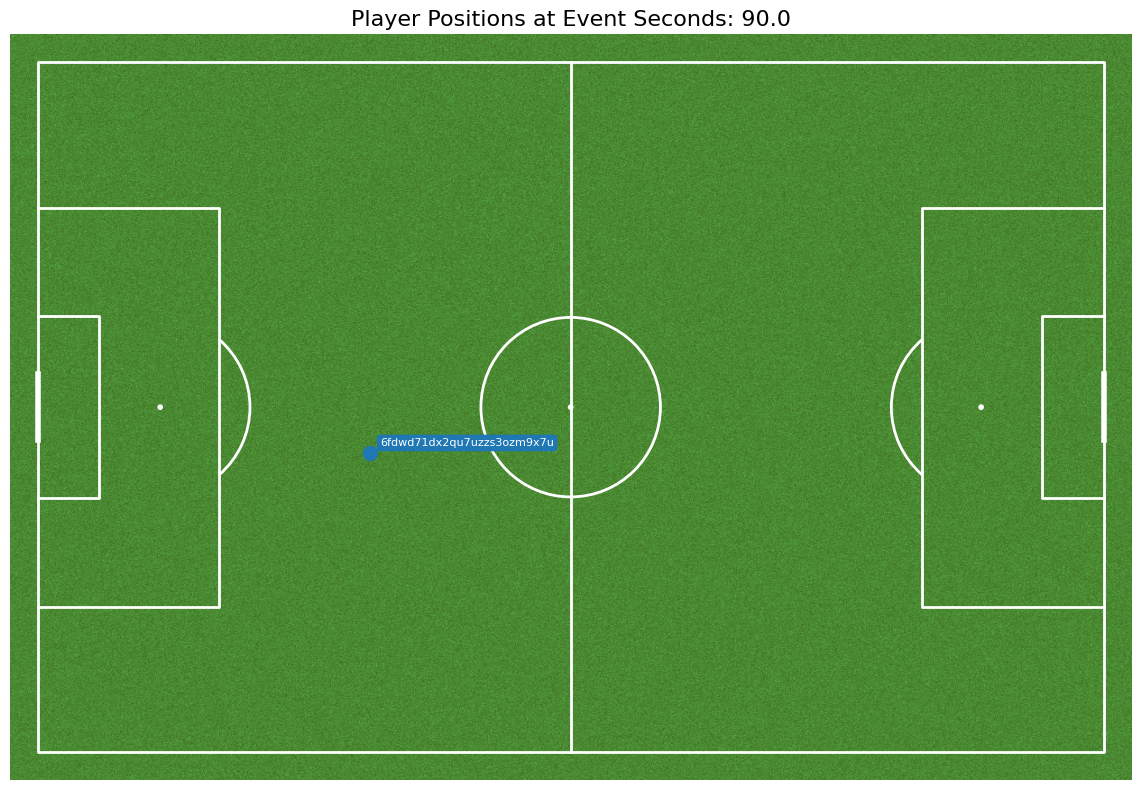

In [9]:
# query = """
# WITH action_changes AS (
#     SELECT
#         a.*,
#         LAG(a.team_id) OVER (ORDER BY a.period_id, a.seconds, a.id) AS prev_team_id,
#         LEAD(a.team_id) OVER (ORDER BY a.period_id, a.seconds, a.id) AS next_team_id
#     FROM
#         spadl_actions a
#     WHERE
#         a.game_id = '5uts2s7fl98clqz8uymaazehg'
# ),

# possession_markers AS (
#     SELECT
#         *,
#         CASE 
#             WHEN prev_team_id IS NULL OR team_id != prev_team_id THEN 1 
#             ELSE 0 
#         END AS is_new_possession
#     FROM
#         action_changes
# ),

# closest_tracking AS (
#     SELECT 
#         pt.*, 
#         sa.id AS action_id,
#         ABS(pt.frame_id - sa.seconds * 25) AS frame_diff,
#         ROW_NUMBER() OVER (PARTITION BY sa.id ORDER BY ABS(pt.frame_id - sa.seconds * 25)) AS rn
#     FROM 
#         spadl_actions sa
#     JOIN 
#         player_tracking pt 
#         ON sa.game_id = pt.game_id 
#         AND sa.period_id = pt.period_id
#         AND sa.player_id = pt.player_id
#     WHERE 
#         sa.game_id = '5uts2s7fl98clqz8uymaazehg'
# )

# SELECT 
#     pm.*, 
#     ct.x AS tracking_x, 
#     ct.y AS tracking_y, 
#     ct.timestamp
# FROM 
#     possession_markers pm
# LEFT JOIN 
#     closest_tracking ct 
#     ON pm.id = ct.action_id
# WHERE 
#     ct.rn = 1
# ORDER BY
# 	pm.period_id ASC,
#     pm.seconds ASC;
#gives columns: id	game_id	period_id	seconds	player_id	team_id	start_x	start_y	end_x	end_y	action_type	result	bodypart	prev_team_id	next_team_id	is_new_possession	tracking_x	tracking_y	timestamp

import matplotlib.pyplot as plt
from mplsoccer import Pitch
import matplotlib as mpl

# Using tracking_df
# def plot_tracking_data(tracking_data):
#     # Define pitch dimensions and colors
#     pitch = Pitch(pitch_color='grass', line_color='white', pitch_type='opta',
#                   pitch_length=105, pitch_width=68)  # Adjust dimensions if necessary
#     fig, ax = pitch.draw(figsize=(12, 8))
    
#     # Extract timestamp and team names
#     timestamp = tracking_data['timestamp'].iloc[0]
#     team_names = tracking_data['team_id'].unique()
#     colors = mpl.colors.TABLEAU_COLORS
#     color_map = {team: color for team, color in zip(team_names, colors.values())}
    
#     # Plot player positions
#     for _, row in tracking_data.iterrows():
#         x = row['x']
#         y = row['y']
#         player_name = row['player_name']
#         team_name = row['team_id']
#         jersey_no = row['jersey_number']
        
#         # Plot the ball
#         if row['player_name'] == 'Ball':
#             pitch.scatter(x, y, s=90, color='yellow', ax=ax, label='Ball')
#         else:
#             # Plot players
#             pitch.scatter(x, y, s=100, color=color_map[team_name], ax=ax, label=team_name)
        
#         # Add player names (excluding the ball)
#         if row['player_name'] != 'Ball':
#             ax.text(x + 2, y + 2, f"{player_name} ({jersey_no})", fontsize=8)
    
#     # Set title
#     ax.set_title(f'Player Positions at Event Timestamp: {timestamp}', fontsize=16)
#     plt.tight_layout()
#     plt.show()

# # Example usage
# frame_id = tracking_df['frame_id'].unique()[0]  
# # You can change this to any specific frame_id you want to visualize
# filtered_tracking_df = tracking_df[tracking_df['frame_id'] == frame_id]

# if filtered_tracking_df.empty:
#     print(f"No data found for frame_id: {frame_id}")
# else:
#     plot_tracking_data(filtered_tracking_df)

# plot for every "seconds", not "timestamp"
def plot_tracking_data(tracking_df): 
    # Define pitch dimensions and colors
    pitch = Pitch(pitch_color='grass', line_color='white', pitch_type='opta',
                  pitch_length=105, pitch_width=68)  # Adjust dimensions if necessary
    fig, ax = pitch.draw(figsize=(12, 8))
    
    # Get the first row's timestamp
    first_seconds = tracking_df['seconds'].iloc[40]
    
    # Filter data for the first event time only
    trackingData = tracking_df[tracking_df['seconds'] == first_seconds]
    
    # Extract team names and define colors
    team_names = trackingData['team_id'].unique()
    colors = list(mpl.colors.TABLEAU_COLORS.values())  # Use a color palette
    color_map = {team: colors[i % len(colors)] for i, team in enumerate(team_names)}
    
    # Plot player positions
    for _, row in trackingData.iterrows():
        x = row['tracking_x']
        y = row['tracking_y']
        player_name = row['player_id']
        team_name = row['team_id']
        
        # Plot players
        pitch.scatter(x, y, s=100, color=color_map[team_name], ax=ax, label=team_name)
        
        # Add player ID near the marker
        ax.text(x + 1, y + 1, f"{player_name}", fontsize=8, color='white', 
                bbox=dict(facecolor=color_map[team_name], edgecolor='none', boxstyle='round,pad=0.3'))
    
    # Set title
    ax.set_title(f'Player Positions at Event Seconds: {first_seconds}', fontsize=16)
    plt.show()

# Call the function with your tracking dataframe
plot_tracking_data(tracking_df)